In [1]:
import os
import pandas as pd
import numpy as np

# Actigraph IMU CSV Pre-processing

In [20]:
file = "TAS1F51160037 (2021-11-21)-IMU-Back-waist.csv"
name = file.strip(".csv")
raw_df = pd.read_csv(file, skiprows=10, header=0)
colnames_dict = {"Timestamp": "timestamps","Accelerometer X": "accel_x",
                 "Accelerometer Y": "accel_y","Accelerometer Z": "accel_z",
                 "Gyroscope X": "gyro_x","Gyroscope Y": "gyro_y", 
                 "Gyroscope Z": "gyro_z","Magnetometer X": "magnet_x",
                 "Magnetometer Y": "magnet_y","Magnetometer Z": "magnet_z"}
raw_df.rename(columns=colnames_dict, inplace = True)
# add unix timestamps
raw_df['unix_timestamps'] = pd.to_datetime(raw_df.timestamps, format="%Y-%m-%dT%H:%M:%S.%f").values.astype(np.int64) // 10**6
# Save results to CSV
processed_file = f'{name}_filtered.csv'
processed_file = "dwight_waist100hz_GYRO_2021-11-21.csv" # for example purposes
# view input data
raw_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2021-11-19T13:47:00.0000000,-0.003418,-0.076172,1.005859,-0.793457,-0.183105,0.12207,1637329620000
1,2021-11-19T13:47:00.0100000,-0.002456,-0.077139,1.002441,-0.854492,-0.122070,0.12207,1637329620010
2,2021-11-19T13:47:00.0200000,-0.003848,-0.076162,1.002500,-0.853272,-0.123291,0.12207,1637329620020
3,2021-11-19T13:47:00.0300000,-0.000991,-0.075669,1.005356,-0.797119,-0.183105,0.12207,1637329620030
4,2021-11-19T13:47:00.0400000,-0.001484,-0.075273,1.004844,-0.910645,-0.180664,0.12207,1637329620040


In [21]:
# Save results to local directory
raw_df.to_csv(processed_file,index=False)

# TURN DETECTION From Gyro Data
USING ALGORITHM FROM https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [22]:
file = "dwight_waist100hz_GYRO_2021-11-21.csv" # for example purposes, substitute in lines below
name = processed_file.strip(".csv")
gyro_df = pd.read_csv(processed_file)
gyro_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2021-11-19T13:47:00.0000000,-0.003418,-0.076172,1.005859,-0.793457,-0.183105,0.12207,1637329620000
1,2021-11-19T13:47:00.0100000,-0.002456,-0.077139,1.002441,-0.854492,-0.122070,0.12207,1637329620010
2,2021-11-19T13:47:00.0200000,-0.003848,-0.076162,1.002500,-0.853272,-0.123291,0.12207,1637329620020
3,2021-11-19T13:47:00.0300000,-0.000991,-0.075669,1.005356,-0.797119,-0.183105,0.12207,1637329620030
4,2021-11-19T13:47:00.0400000,-0.001484,-0.075273,1.004844,-0.910645,-0.180664,0.12207,1637329620040


### Filter and Visualize Input Signal

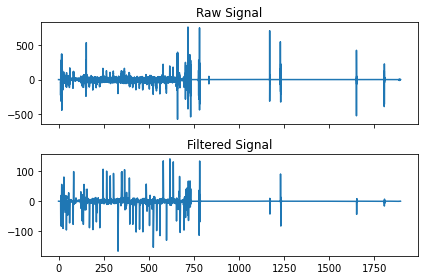

In [23]:
from scipy import signal
import matplotlib.pyplot as plt
import math

# extract vertical component of angular velocity
sig = gyro_df['gyro_y']
# apply 1.5Hz 4th order Butterworth filter
order = 4
filter_freq = 0.5
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered = signal.sosfilt(sos, sig)
# transform time to 0 and rescale to seconds from ms
time = (gyro_df['unix_timestamps'] - min(gyro_df['unix_timestamps']))/1000

# plot the raw and filtered signals
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(time, sig)
ax1.set_title("Raw Signal")
ax2.plot(time, filtered)
ax2.set_title("Filtered Signal")
plt.tight_layout()
plt.show()

### Turn Detection
Algorithm is modeled directly from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/, with some parameters adjusted to better fit the Actigraph sensor input

In [25]:
# local_maxima = abs(filtered) > 15
candidate_turns = []
candidate_min_peak_mag = 15 # minimum required angular velocity peak magnitude for each candidate turn segment
turning = False
start = 0
for i in range(0, len(filtered)):
    # currently turning
    if turning:
        # check for turn end when |angular velocity| < 5
        if abs(filtered[i]) < 5:
            # add segment to candidate turn if |max angular velocity| >= 15
            if max(abs(filtered[start:i])) >= candidate_min_peak_mag:
                candidate_turns.append((start, i-1))
            turning = False
    # not turning
    else:
        # check for turn start when |angular velocity| >= 5
        if abs(filtered[i]) >= 5:
            turning = True
            start = i

# combine same-direction turns separated by < 0.05 seconds
combined_turns = [candidate_turns[0]]
for (turn_start, turn_end) in candidate_turns[1:]:
    prev_turn = combined_turns[-1]
    intra_turn_duration = time[turn_start] - time[prev_turn[1]] 
    # combine same-direction turns with intra-turn duration < 0.05s
    if intra_turn_duration < 0.05 and filtered[turn_start]*filtered[prev_turn[1]] > 0:
        combined_turns[-1] = (prev_turn[0], turn_end)
    # add current turn as separate turn instance
    else:
        combined_turns.append((turn_start, turn_end))

# keep turns within 0.5s - 10s window and >= 45 degree turn angle
final_turns = []
for (turn_start, turn_end) in combined_turns:
    # check turn duration for 0.5s - 10s
    turn_duration = time[turn_end] - time[turn_start]
    if turn_duration >= 0.5 and turn_duration <= 10:
        # check turn angle for >= 45 degrees
        turn_angle = turn_duration*sum(abs(filtered[turn_start:turn_end+1]))
        if turn_angle >= 45:
            final_turns.append((turn_start, turn_end))

### Visualize Turns
Static and interactive plots for visualizing turns on the filtered signal

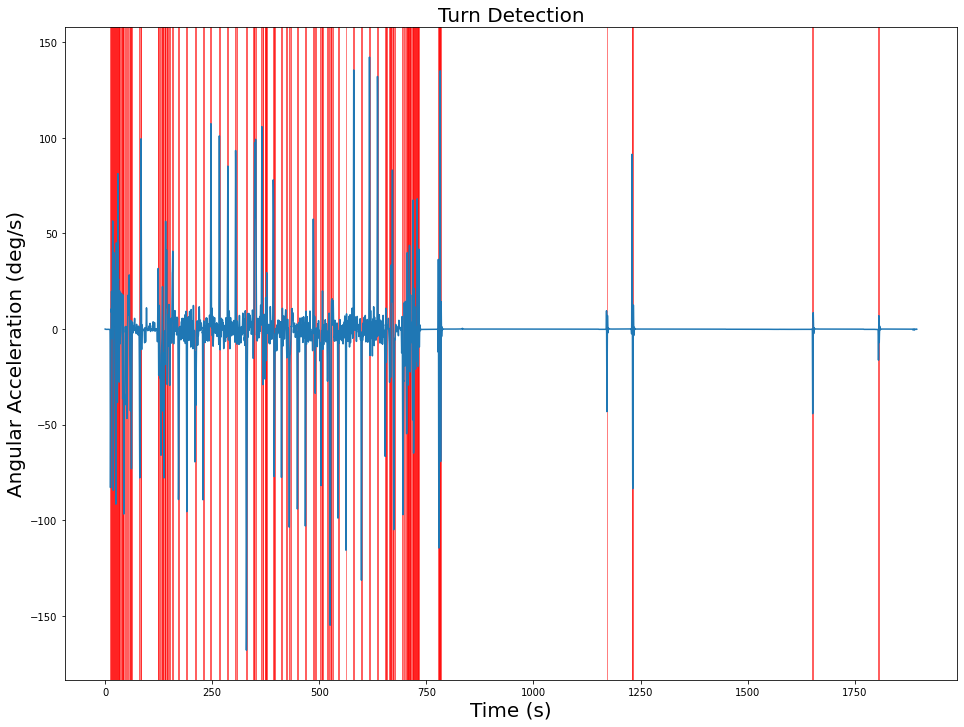

In [26]:
plt.plot(time, filtered)
plt.title("Turn Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Angular Acceleration (deg/s)",fontsize=20)
for turn_start, turn_end in final_turns:
    time_start = time[turn_start]
    time_end = time[turn_end]
    plt.axvspan(time_start, time_end, color='red', alpha=0.5)
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_turns.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

### Make an Interactive Plot for Visualizing Turn data

In [27]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

# instantiating the figure object
graph = figure(title="Turn Analysis Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Angular Acceleration (deg/s)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
 
# plotting the 1st line graph
#graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
graph.line(x, y, line_color="blue") 

# add annotation boxes for all turns
for turn_start, turn_end in final_turns:
    time_start = time[turn_start]
    time_end = time[turn_end]
    graph.add_layout(BoxAnnotation(left=time_start, right=time_end, fill_alpha=0.2, fill_color='red'))
 
# displaying the model
show(graph)

In [28]:
from bokeh.plotting import save

# save results to html file
interactive_plot_fname = f"{name}_turns.html"
output_file(filename=interactive_plot_fname, title="Turn Analysis Plot")
save(graph)

'D:\\evgeni\\GitRepos\\GaitPy\\gaitpy\\demo\\dwight_waist100hz_GYRO_2021-11-21_turns_gyroY.html'

# Bout and Step Detection Using Gyro Data
from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [469]:
file = "dwight_waist100hz_GYRO_2021-11-21.csv" # for example purposes, substitute in lines below
name = processed_file.strip(".csv")
gyro_df = pd.read_csv(processed_file)
gyro_df.head()

,timestamps,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2021-11-21T18:30:00.0000000,-0.915527,-0.732422,0.366211,1637519400000
1,2021-11-21T18:30:00.0100000,-1.100464,-0.485230,0.367432,1637519400010
2,2021-11-21T18:30:00.0200000,-1.282959,-0.174561,0.489502,1637519400020
3,2021-11-21T18:30:00.0300000,-1.337280,0.251465,0.552979,1637519400030
4,2021-11-21T18:30:00.0400000,-1.166992,0.502930,0.668945,1637519400040


## Detect Bouts using Combined Rotational Data

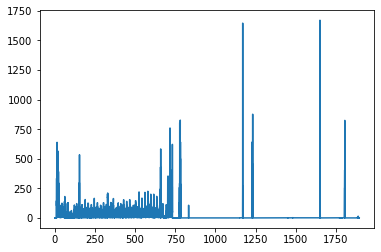

In [30]:
# calculate total rotational rate
gyro_t = np.sqrt(sum([np.square(gyro_df['gyro_x']),np.square(gyro_df['gyro_y']),np.square(gyro_df['gyro_z'])]))
# transform time to 0 and rescale to seconds from ms
time = (gyro_df['unix_timestamps'] - min(gyro_df['unix_timestamps']))/1000
plt.plot(time,gyro_t)

In [31]:
# calculate bouts using thresholding
bout_min_angular_vel = 15
candidate_bouts = []
is_bout = False
start = 0
for i in range(0, len(gyro_t)):
    # currently measuring a bout
    if is_bout:
        # check for bout end when |total angular velocity| < bout minimum threshold
        if gyro_t[i] < bout_min_angular_vel:
            candidate_bouts.append((start, i-1))
            is_bout = False
    # not a bout
    else:
        # check for turn start when |angular velocity| >= 5
        if gyro_t[i] >= bout_min_angular_vel:
            is_bout = True
            start = i

# combine candidate bouts separated by less than 2.5 seconds of activity
bout_max_seperation = 2.5
final_bouts = [candidate_bouts[0]]
for bout_start, bout_end in candidate_bouts[1:]:
    prev_bout = final_bouts[-1]
    intra_bout_duration = time[bout_start] - time[prev_bout[1]] 
    if intra_bout_duration < bout_max_seperation:
        final_bouts[-1] = (prev_bout[0], bout_end)
    else:
        final_bouts.append((bout_start, bout_end))

# eliminate bouts < 3 seconds in duration
final_bouts = [bout for bout in final_bouts if time[bout[1]]-time[bout[0]]>3.00]
print(final_bouts)

[(1112, 6898), (7167, 8459), (9099, 9888), (10980, 11608), (11903, 67580), (69126, 73232), (77583, 78302), (122800, 123254)]


### Visualize Results

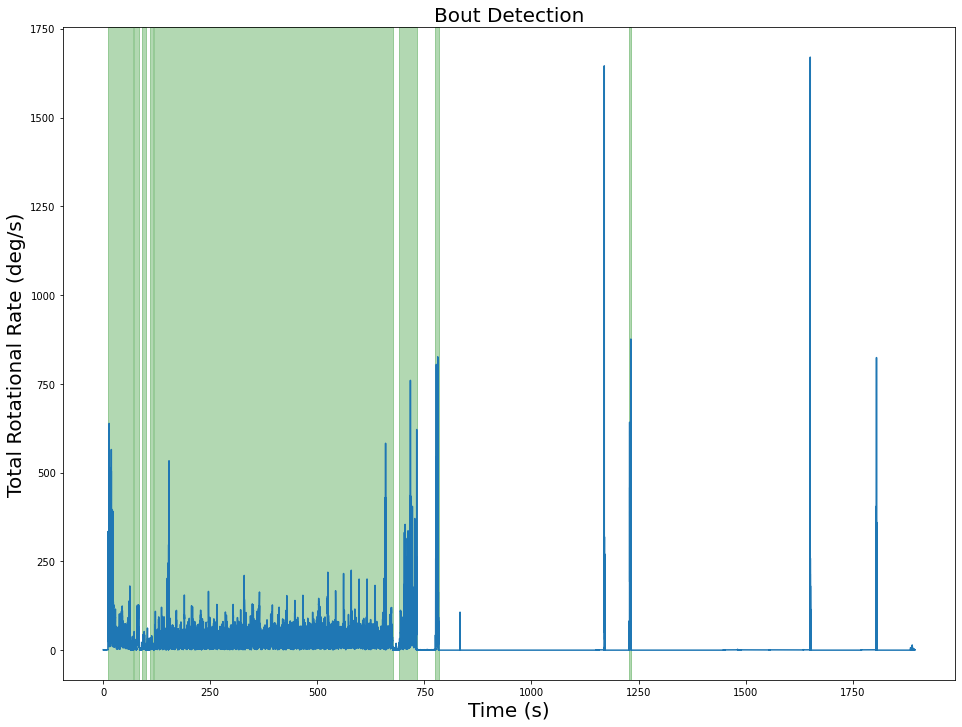

In [32]:
plt.plot(time, gyro_t)
plt.title("Bout Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Total Rotational Rate (deg/s)",fontsize=20)
for bout_start, bout_end in final_bouts:
    time_start = time[bout_start]
    time_end = time[bout_end]
    plt.axvspan(time_start, time_end, color='green',alpha=0.3)
    #plt.axvline(time_start,color='green')
    #plt.axvline(time_end,color='red') 
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_turns.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

In [36]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

# instantiating the figure object
bout_graph = figure(title="Bout Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Total Rotational Rate (deg/s)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = gyro_t
 
# plotting the 1st line graph
#bout_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
bout_graph.line(x, y, line_color="blue") 


# add annotation boxes for all turns
for bout_start, bout_end in final_bouts:
    time_start = time[bout_start]
    time_end = time[bout_end]
    bout_graph.add_layout(BoxAnnotation(left=time_start, right=time_end, fill_alpha=0.2, fill_color='red'))
 
# displaying the model
show(bout_graph)

In [37]:
# Save plot to html file
interactive_plot_fname = f"{name}_bouts.html"
output_file(filename=interactive_plot_fname, title="Bout Detection Graph")
save(bout_graph)

'D:\\evgeni\\GitRepos\\GaitPy\\gaitpy\\demo\\dwight_waist100hz_GYRO_2021-11-21_turns.html'

## STEP DETECTION

#### Algorithm 1: Use candidate bouts and signal from gyroscope to determine steps
from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [38]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

# choose signal for step detection
#step_signal = gyro_df['gyro_y'] # use the raw gyro data
step_signal = filtered # use the filtered gyro data

# assume maximum step cadence of 240 steps/min
max_cadence = 240
min_step_separation = 60/max_cadence # in seconds

# candidate steps
candidate_steps = {}

# select all mid-swing (peak pitch angular velocity) candidates from each bout
for (idx, (bout_start, bout_end)) in enumerate(final_bouts):
    peaks = find_peaks(step_signal[bout_start:bout_end], height=None)[0]
    #peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))
    
    # remove bouts with less than 3 steps and fewer than 3 seconds in duration
    if peaks.size > 3:
        candidate_steps[idx] = peaks.tolist()

# detect steps across entire signal
'''
peaks = find_peaks(step_signal, height=None)[0]
#peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))

# remove bouts with less than 3 steps and fewer than 3 seconds in duration
if peaks.size > 3:
    candidate_steps[idx] = peaks.tolist()
'''

print("Number of steps in each bout")
for step_arr in candidate_steps.values():
    print(len(step_arr))
    #print(step_arr.size)
# remove candidate steps shorter than 0.25 seconds in duration (>240 steps/min)

Number of steps in each bout
23
6
5
265
16
4


### Visualize Results

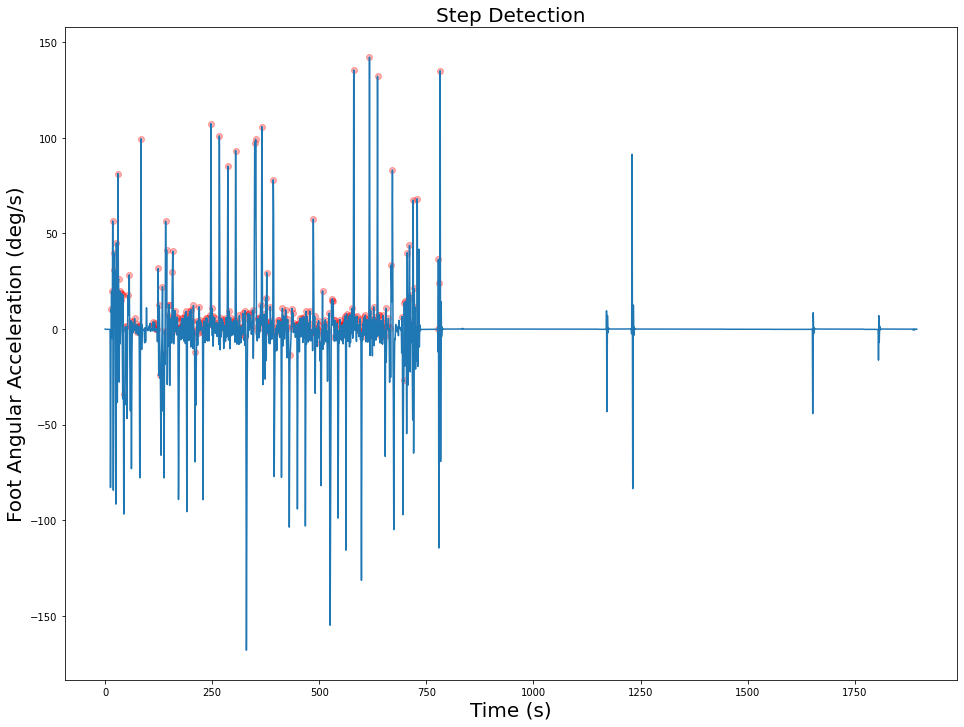

In [39]:
# display the midswing detection results
plt.plot(time, step_signal)
plt.title("Step Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Foot Angular Acceleration (deg/s)",fontsize=20)
for key in candidate_steps:
    bout_start = final_bouts[key][0]
    #bout_start = 0
    step_arr = candidate_steps[key]
    time_arr = [time[step+bout_start] for step in step_arr]
    step_swing_midpoint = [step_signal[step+bout_start] for step in step_arr]
    plt.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.3)
    #plt.axvline(time_start,color='green')
    #plt.axvline(time_end,color='red') 
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_TURNS_GyroX_1.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

#### Algorithm 2: Use accelerometer data to determine steps

In [34]:
file = "dwight_waist100hz_2021-11-19.csv" # for example purposes, substitute in lines below
name = processed_file.strip(".csv")
accel_df = pd.read_csv(processed_file)
accel_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2021-11-19T13:47:00.0000000,-0.003418,-0.076172,1.005859,-0.793457,-0.183105,0.12207,1637329620000
1,2021-11-19T13:47:00.0100000,-0.002456,-0.077139,1.002441,-0.854492,-0.122070,0.12207,1637329620010
2,2021-11-19T13:47:00.0200000,-0.003848,-0.076162,1.002500,-0.853272,-0.123291,0.12207,1637329620020
3,2021-11-19T13:47:00.0300000,-0.000991,-0.075669,1.005356,-0.797119,-0.183105,0.12207,1637329620030
4,2021-11-19T13:47:00.0400000,-0.001484,-0.075273,1.004844,-0.910645,-0.180664,0.12207,1637329620040


### Filter and Visualize Accelerometer Signal

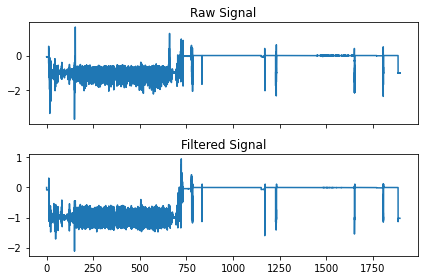

In [588]:
# extract vertical component of linear acceleration
sig = accel_df['accel_y']
# apply 20Hz 4th order Butterworth filter
order = 4
filter_freq = 4.0
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered = signal.sosfilt(sos, sig)
# transform time to 0 and rescale to seconds from ms
time = (accel_df['unix_timestamps'] - min(accel_df['unix_timestamps']))/1000

# plot the raw and filtered signals
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(time, sig)
ax1.set_title("Raw Signal")
ax2.plot(time, filtered)
ax2.set_title("Filtered Signal")
plt.tight_layout()
plt.show()

### Step Detection
Method adapted from https://ieeexplore.ieee.org/document/7078919 

In [589]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

# choose signal for step detection
#step_signal = accel_df['y'] # use the raw acceleration data
step_signal = filtered # use the filtered acceleration data

# assume maximum step cadence of 240 steps/min
max_cadence = 240
min_step_separation = 60/max_cadence # in seconds

# candidate steps
candidate_steps = {}

# select all mid-swing (peak pitch angular velocity) candidates from each bout
for (idx, (bout_start, bout_end)) in enumerate(final_bouts):
    peaks = find_peaks(step_signal[bout_start:bout_end], height=None, prominence=0.1, distance=min_step_separation*100)[0] + bout_start
    #peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))
    
    # remove bouts with less than 3 steps and fewer than 3 seconds in duration
    if peaks.size > 3:
        candidate_steps[idx] = peaks.tolist()
'''
# detect steps across entire signal
peaks = find_peaks(step_signal, height=None, distance=min_step_separation*100, prominence=0.1)[0]
# assume trophs correspond to peaks of other footstep to find total footsteps
# trophs = find_peaks(-step_signal, height=None, distance=min_step_separation*100, prominence=0.1)[0]
# peaks = np.concatenate((peaks,trophs), 0)
#peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))

# remove bouts with less than 3 steps and fewer than 3 seconds in duration
if peaks.size > 3:
    candidate_steps[0] = peaks.tolist()
'''
for step_arr in candidate_steps.values():
    print(len(step_arr))
    #print(step_arr.size)

819
41


### Visualize Results

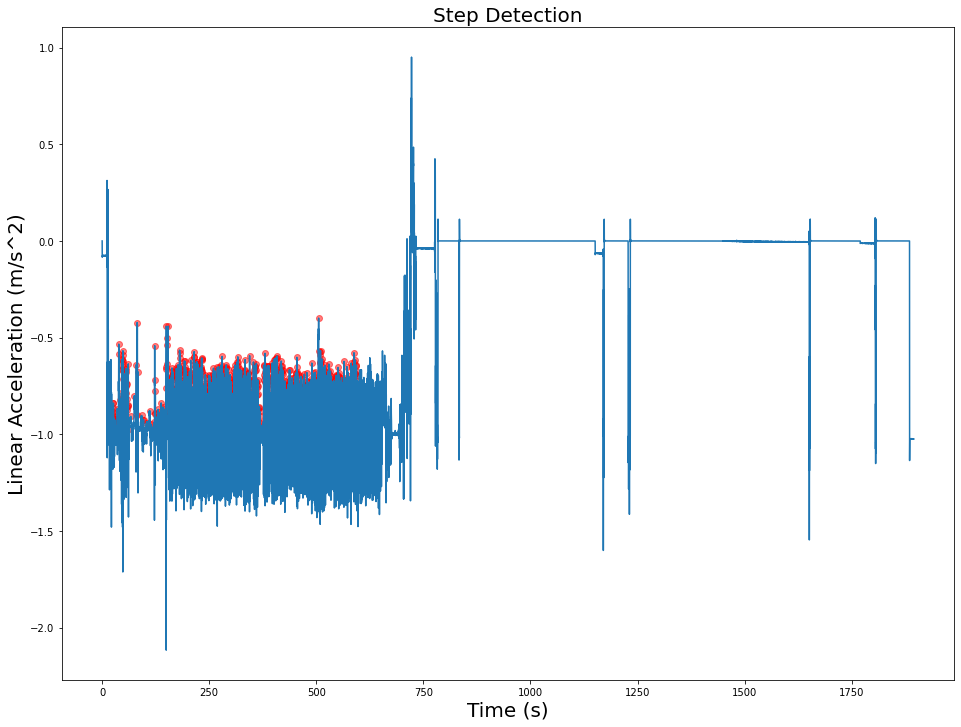

In [590]:
# display the midswing detection results
plt.plot(time, step_signal)
plt.title("Step Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Linear Acceleration (m/s^2)",fontsize=20)
for key in candidate_steps:
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [step_signal[step] for step in step_arr]
    plt.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.5)
figure = plt.gcf()
figure.set_size_inches(16,12)
#filename = input("Enter filename ")
#out_fig = name + filename
#plt.savefig(out_fig, dpi=300)
plt.show()

In [586]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

# instantiating the figure object
step_graph = figure(title="Step Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Linear Acceleration (m/s^2)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
horizontal_motion = accel_df['x']
 
# plotting the 1st line graph
#step_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
step_graph.line(x, y, line_color="blue")
#step_graph.line(x, horizontal_motion, line_color="green")

# highlight midpoint of swing for all steps
for key in candidate_steps:
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [step_signal[step] for step in step_arr]
    step_graph.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.5)
 
# displaying the model
show(step_graph)

In [ ]:
# Save plot to html file
interactive_plot_fname = f"{name}_steps.html"
output_file(filename=interactive_plot_fname, title="Step Detection Graph")
save(step_graph)

# Feature Analysis from Step Data

10.0
Number of detected IC events: 1252
Number of detected FC events: 1554


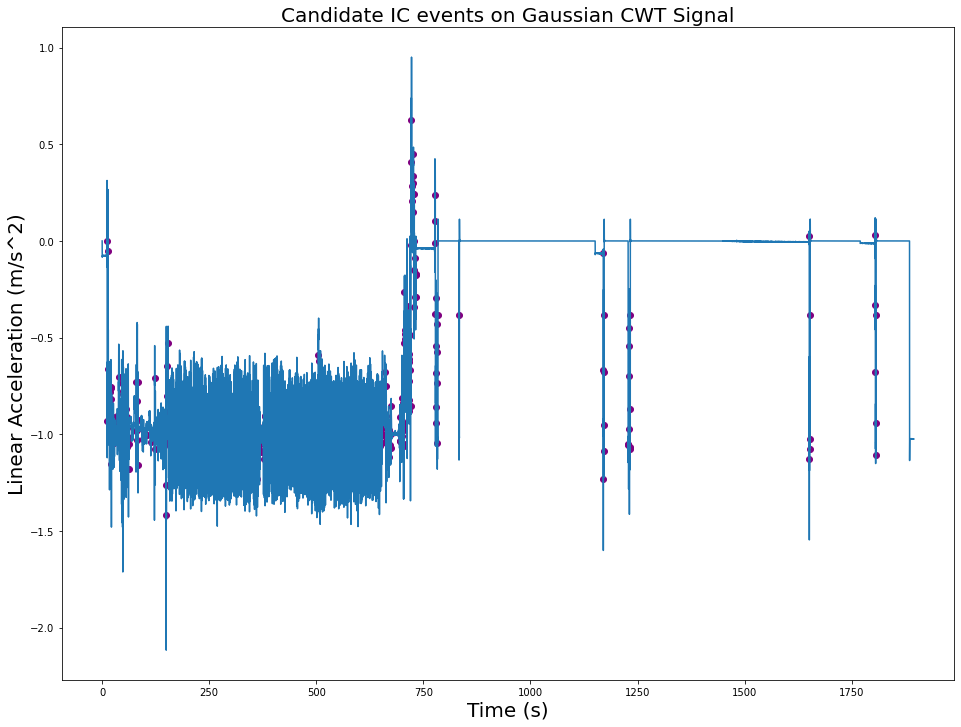

In [592]:
import pywt
import scipy.signal as signal
from scipy.integrate import cumtrapz

# convert chosen wavelet scale to frequency
sampling_rate = 0.01 # 100Hz sampling frequency
wavelet_scale = 2
print(pywt.scale2frequency("gaus1",wavelet_scale)/sampling_rate)

# apply gaussian continuous wavelet transform to filtered accelerometer signal
#integrated_signal = cumtrapz(filtered,initial=0)
integrated_signal = filtered
filtered_transformed = pywt.cwt(integrated_signal,wavelet_scale,"gaus1")[0].flatten()

# compute local minima to find potential IC events
ic_event = signal.find_peaks(-filtered_transformed,prominence=0.1)[0]

# find FC events using local maxima of 
filtered_transformed_cwt = pywt.cwt(filtered_transformed,wavelet_scale,"gaus1")[0].flatten()
fc_event = signal.find_peaks(filtered_transformed_cwt,prominence=0.1)[0]

print(f"Number of detected IC events: {len(ic_event)}")
print(f"Number of detected FC events: {len(fc_event)}")

# display candidate IC events
plt.plot(time, filtered)
plt.title("Candidate IC events on Gaussian CWT Signal",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Linear Acceleration (m/s^2)",fontsize=20)
IC = []
time_arr = [] 
for idx in ic_event:
    IC.append(filtered[idx])
    time_arr.append(time[idx])
plt.scatter(time_arr, IC, color='purple',alpha=1.0)
figure = plt.gcf()
figure.set_size_inches(16,12)
#filename = input("Enter filename ")
#out_fig = name + filename
#plt.savefig(out_fig, dpi=300)
plt.show()

### Visualize Foot Contact Events

In [593]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

# instantiating the figure object
contact_graph = figure(title="Step and IC Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Linear Acceleration (m/s^2)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
 
# plotting the 1st line graph
#contact_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
contact_graph.line(x, y, line_color="blue")
#contact_graph.line(x, filtered_transformed, line_color="green", line_dash="dashed")

# highlight IC events
IC = []
time_arr = [] 
for idx in ic_event:
    IC.append(y[idx])
    time_arr.append(time[idx])
contact_graph.scatter(time_arr, IC, color='green',alpha=1.0,legend="Initial Contact (IC)")
# highlight FC events
FC = []
time_arr = []
for idx in fc_event:
    FC.append(y[idx])
    time_arr.append(time[idx])
contact_graph.scatter(time_arr, FC, color='purple',alpha=1.0,legend="Final Contact (FC)")
    
 
# highlight midpoint of swing for all steps
for key in candidate_steps:
    bout_start = final_bouts[key][0]
    #bout_start = 0
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [y[step] for step in step_arr]
    contact_graph.scatter(time_arr, step_swing_midpoint, color='red',alpha=1.0,legend="Gait Midswing")
    
# displaying the model
show(contact_graph)

In [ ]:
# Save plot to html file
interactive_plot_fname = f"{name}_contact-events.html"
output_file(filename=interactive_plot_fname, title="Foot Contact Events Graph")
save(contact_graph)

### Compute Gait Features using contact events and filtered signal

In [579]:
import copy
final_steps = copy.deepcopy(candidate_steps)

# filter horizontal activity data
filtered_horizontal = signal.sosfilt(sos, accel_df['x'])

# match IC and FC events with detected steps
for bout_idx in final_steps:
    step_arr = final_steps[bout_idx]
    step_idx = 0
    ic_idx = 0
    fc_idx = 0
    number_of_steps = len(step_arr)
    IC_final = np.zeros((number_of_steps,))
    FC_final = np.zeros((number_of_steps,))
    # group IC and FC events with each detected step
    for i in range(0,number_of_steps):
        cur_step = step_arr[i]
        # find closest prior initial contact point
        while ic_idx < len(ic_event) and ic_event[ic_idx] < cur_step:
            ic_idx += 1
        ic_idx -= 1
        # find closest successive final contact point
        while fc_idx < len(fc_event) and fc_event[fc_idx] < cur_step:
            fc_idx += 1
        # add IC and FC events to arrays
        IC_final[i] = ic_event[ic_idx]
        FC_final[i] = fc_event[fc_idx]
        
        # OPTIONAL if IC and FC too far apart, change current step to -1 to indicate it's invalid 
        #print(f"Step: {cur_step}, IC idx: {ic_idx}, IC event: {ic_event[ic_idx]}, FC idx: {fc_idx}, FC event: {fc_event[fc_idx]}")
        
    # add IC and FC events to step dict
    final_steps[bout_idx] = [step_arr, IC_final, FC_final]

# determine size of output table
table_size = 0
bouts = []
bout_start_time = []
bout_end_time = []
for bout_idx in final_steps:
    step_arr, IC_arr, FC_arr = final_steps[bout_idx]
    number_of_steps = len(step_arr)
    table_size += number_of_steps - 2
    bouts = bouts + [bout_idx]*(number_of_steps-2)
    bout_start_time = bout_start_time + [final_bouts[bout_idx][0]]*(number_of_steps-2)
    bout_end_time = bout_end_time + [final_bouts[bout_idx][1]]*(number_of_steps-2)
    
# initialize output table
feature_df = pd.DataFrame({"Bout":bouts,"Start Time(s)":bout_start_time,"End Time(s)":bout_end_time},
                         columns=["Bout","Start Time(s)","End Time(s)","stride duration","step duration",
                                  "stance duration","swing duration","cadence"])   

row = 0
for bout_idx in final_steps:
    step_arr, IC_arr, FC_arr = final_steps[bout_idx]
    step_idx = 0
    number_of_steps = len(step_arr)
    #print(IC_arr)
    for i in range(0,number_of_steps-2):
        cur_step = step_arr[i]
        IC = IC_arr[i]
        FC = FC_arr[i]
        
        # stance time = FC(i+1) - IC(i)
        stance_duration = time[FC_arr[i+1]] - time[IC]
                
        # step duration = IC from one foot to the other
        step_duration = time[IC_arr[i+1]]-time[IC]
                
        # stride duration = IC from one foot to the same foot
        stride_duration = time[IC_arr[i+2]]-time[IC]
        
        # swing time = stride time - stance time
        swing_duration = stride_duration - stance_duration
        
        # calculate cadence = strides per minute
        cadence = 60 / stride_duration
        
        # calculate stride length using inverted pendulum model
        #l = 0.9
        #h = cumtrapz(cumtrapz(filtered,initial=0),initial=0)
        #step_length = 2*np.sqrt(2*l*h - h*h)
        
        feature_df.loc[row,["stride duration","step duration","stance duration","swing duration","cadence"]] = [stride_duration,step_duration,stance_duration,swing_duration,cadence]
        row += 1
        #print(f"Stance {stance_duration}, Step {step_duration}, Stride {stride_duration}, Swing {swing_duration}, Cadence {cadence}") 
    
feature_df

d:\evgeni\conda_environments\gaitpy\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


,Bout,Start Time(s),End Time(s),stride duration,step duration,stance duration,swing duration,cadence
0,1,2281,57241,11.19,4.39,9.75,1.44,5.36193
1,1,2281,57241,8.37,6.8,8.16,0.21,7.16846
2,1,2281,57241,3.02,1.57,2.7,0.32,19.8675
3,1,2281,57241,7.65,1.45,6.01,1.64,7.84314
4,1,2281,57241,6.2,6.2,44.89,-38.69,9.67742
5,1,2281,57241,39.44,0,38.69,0.75,1.5213
6,1,2281,57241,42.06,39.44,40.59,1.47,1.42653
7,1,2281,57241,2.62,2.62,14.7,-12.08,22.9008
8,1,2281,57241,0,0,12.08,-12.08,inf
9,1,2281,57241,11.3,0,12.08,-0.78,5.30973


In [581]:
# save results
feature_df.to_csv(f"{name}_gait-features.csv",index=False)